## IMPORT MODULES AND DATA PROCESSING

In [100]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## IMPORT PACKAGES
import warnings
import numpy as np
import torch
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from data_processing.read_data import generate_MAPAL_data,generate_new_data
from annotator.Model import Annotator_1,Annotator_2
from classifier.Model import LR,PWC
from classifier.trainer import train_LR
from classifier.evaluation import eval_model,classf_eval_after_warmup,classf_eval_after_training, compare_true_label,print_scores
from classifier.warmup import warmedup_classifiers
from annotator.warmup import annotator_warmup
from annotator.evaluation import eval_annotator_model,annot_eval_after_warmup, annot_eval_after_training
from AL_design.train_scheme import AL_train_cycle,AL_train_majority,AL_train_MAPAL_instances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from stats.utils import diverse_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
if torch.cuda.is_available(): 
 device = "cuda:0" 
else: 
 device = "cpu" 

In [102]:
def set_seed(seed: int = 42) -> None:  ## Set SEEDS FUNCTION
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    # os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [103]:
seed = 1
set_seed(seed)

Data_path = "/Users/kaizer/Documents/Active Learning/Code/MAAL/Multi-Annotator-HIL/data/medical.csv"
budget = 0.2
test_ratio = 0.4
boot_size = 0.1



Random seed set as 1


In [104]:
# ## RUN CELL TO GENERATE FRESH DATA
# TRAIN, VAL, BOOT, ACTIVE, budget = generate_new_data(Data_path,test_ratio=test_ratio,boot_size = boot_size, seed = seed)
# x_train, y_train, y_annot_train = TRAIN
# x_val, y_val, y_annot_val = VAL
# x_boot, y_boot, y_annot_boot = BOOT
# x_active, y_active, y_annot_active = ACTIVE
# m = y_annot_active.shape[1]

In [105]:
## RUN MAPAL
! python3 src/evaluation_scripts/experimental_setup.py \
  --query_strategy mapal-1-0.0001-2-1-entropy \
  --data_set medical \
  --results_path results/medical/csvs \
  --test_ratio 0.4 \
  --budget 0.2 \
  --seed 1

TYPE dataset :  <class 'pandas.core.frame.DataFrame'>
TYPE dataset :  <class 'pandas.core.frame.DataFrame'>
medical: (62, array([ 71, 216]), array([0.79790941, 0.83623693, 0.7804878 , 0.83972125, 0.85017422,
       0.71080139]))
seed: 1
bandwidth: 1.9718004515812175
prior = [0.0001 0.    ]
budget: 0
is_unlabeled type :  <class 'numpy.ndarray'>
is_unlabeled shape :  (172, 6)
unlabeled_indices shape :  (172,)
n_labels_per_annotator :  [0 0 0 0 0 0]
scores shape : (filled with nan ) (172, 6)
fit beta annotators model
(172, 62)
(172, 6)
estimate mean annotation performance
self bam prediction shape :  (6, 172, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
A_mean shape :  (172, 6)
mean annotation performance values: [1. 1. 1. 1. 1. 1.]
n_labels_per_annotator [0 0 0 0 0 0]
A shape :  (172, 2)
[1. 1.]
c :  [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
Z shape :  (172, 2)
Z :  [0. 0.]
K_x shape : 

In [106]:
## RUN CELL TO USE MAPAL GENERATED DATA

TRAIN, VAL, BOOT, ACTIVE, instance_annotator_pair, Mapal_Data, ordered_instances, budget, MAPAL_results_path = generate_MAPAL_data(boot_size,seed)
x_train, y_train, y_annot_train = TRAIN
x_val, y_val, y_annot_val = VAL
x_boot, y_boot, y_annot_boot = BOOT
x_active, y_active, y_annot_active = ACTIVE
m = y_annot_active.shape[1]
new_x_train,new_y_train,new_y_annot_train = Mapal_Data
Mapal_Data_Frame = pd.read_csv(MAPAL_results_path)
Mapal_Data_Frame

Train features shape, Train labels shape, Train Annotator Labels shape
(172, 62) (172,) (172, 6)
Validation features Shape, Validation labels shape, Validation Annotators Label shape
(115, 62) (115,) (115, 6)
(172, 62) (172,) (172, 6)
boot up (array([0, 1]), array([ 5, 12])) 17
active up (array([0, 1]), array([ 44, 111]))
valid up (array([0, 1]), array([22, 93]))
Boot Data Features shape, Boot Data Labels shape, Boot Data Annotator Labels shape
(17, 62) (17,) (17, 6)
Active Data Features shape, Active Data Labels shape, Active Data Annotator Labels shape
(155, 62) (155,) (155, 6)
MAPAL budget :  206
Our Budget :  104


,index,train-micro-misclf-rate,test-micro-misclf-rate,train-macro-misclf-rate,test-macro-misclf-rate,n-labeled-samples,n-true-labels-0,n-false-labels-0,n-true-labels-1,n-false-labels-1,...,n-false-labels-2,n-true-labels-3,n-false-labels-3,n-true-labels-4,n-false-labels-4,n-true-labels-5,n-false-labels-5,n-true-labels,n-false-labels,times
0,0,0.436047,0.530435,0.474365,0.494379,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,1,0.284884,0.191304,0.500000,0.500000,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.017446
2,2,0.284884,0.191304,0.500000,0.500000,2,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0.014926
3,3,0.284884,0.191304,0.500000,0.500000,3,0,1,1,0,...,0,0,0,0,0,0,0,2,1,0.014512
4,4,0.284884,0.191304,0.500000,0.500000,4,0,1,1,0,...,0,1,0,0,0,0,0,3,1,0.014793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,0.174419,0.208696,0.207898,0.337243,144,44,8,18,2,...,11,30,7,28,7,11,11,156,46,0.014058
203,203,0.168605,0.191304,0.203833,0.326491,144,44,8,18,2,...,11,30,7,29,7,11,11,157,46,0.014154
204,204,0.168605,0.191304,0.203833,0.326491,144,44,8,18,2,...,11,30,7,29,7,12,11,158,46,0.013941
205,205,0.168605,0.191304,0.203833,0.326491,144,44,8,19,2,...,11,30,7,29,7,12,11,159,46,0.013909


In [107]:
data_c_AM = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on Annotator Model Labels
data_c_WO = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on W Optimal Labels
data_c_AM_EE = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on Annotator Model Labels with Exploration-Exploitation
data_c_M = [{},{},{},{}]    ## Store Classifier Metrics corresponsind to classifier trained on Majority Labels
data_c_MAPAL = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on MAPAL selected instances 

data_a_AM = [{},{}] ## Store Annotator Metrics corresponsind to classifier trained on Annotator Model Labels
data_a_WO = [{},{}]  ## Store Annotator Metrics corresponsind to classifier trained on W Optimal Labels
data_a_AM_EE = [{},{}]  ## Store Annotator Metrics corresponsind to classifier trained on Annotator Model Labels with Exploration-Exploitation
data_a_M = [{},{}]     ## Store Annotator Metrics corresponsind to classifier trained on Majority Labels
data_a_MAPAL = [{},{}]  ## Store Classifier Metrics corresponsind to classifier trained on MAPAL selected instances 

classifier_model = LR(max_iter=100)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    classifier_model.train(new_x_train,new_y_train)
y_LR_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Logistic Regression Classifier')
a,f = eval_model(y_val, y_LR_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = PWC(2)
classifier_model.train(new_x_train,new_y_train)
y_PWC_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Parzen Window Classifier')
a,f = eval_model(y_val, y_PWC_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = LR(max_iter=100)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    classifier_model.train(x_train,y_train)
y_LR_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING WITH Logistic Regression Classifier')
a,f = eval_model(y_val, y_LR_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = PWC(2)
classifier_model.train(x_train,y_train)
y_PWC_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING WITH Parzen Window Classifier')
a,f = eval_model(y_val, y_PWC_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)



FULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Logistic Regression Classifier
Accuracy:: 0.8
F1 score ::  0.8795811518324608


FULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Parzen Window Classifier
Accuracy:: 0.6869565217391305
F1 score ::  0.783132530120482


FULLY SUPERVISED LEARNING WITH Logistic Regression Classifier
Accuracy:: 0.808695652173913
F1 score ::  0.8888888888888888


FULLY SUPERVISED LEARNING WITH Parzen Window Classifier
Accuracy:: 0.7565217391304347
F1 score ::  0.8390804597701149


## OPTION 1 --- LABELS FROM ANNOTATOR MODEL ( SCHEME 1 )

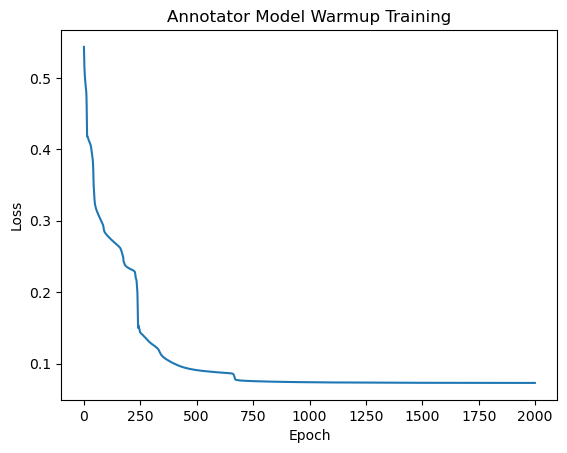

In [108]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]
# torch.manual_seed(seed)
annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 2000,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_AM)

    ## assign seed on LR
    classifier_model_AM = LR(max_iter = 2000)  ## Classifier to be trained on Annotator Model Labels
    classifier_model_WO = LR(max_iter = 2000)  ## Classifier to be trained based on Optimal Weights
    classifier_model_M = LR(max_iter = 2000)  ## Classifier to be trained on Majority Labels
    classifier_model_TL = LR(max_iter = 2000) ## Classifier to be trained on True Labels of chosen instances
    # classifier_model_1 = PWC(2)
    # classifier_model_2 = PWC(2)
    # classifier_model_3 = PWC(2)
    # classifier_model_4 = PWC(2)
    Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
    Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

    classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_AM)

In [109]:
batch_size = 4
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 1000, learning_rate = 0.0001,scheme = 1,RL_flag = 0, ee_ratio = 0, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 104/104 [03:33<00:00,  2.05s/it]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.782608695652174

F1 Score :  0.835680751173709

Confusion Matrix
[[37 20]
 [15 89]]

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        57
           1       0.82      0.86      0.84       104

    accuracy                           0.78       161
   macro avg       0.76      0.75      0.76       161
weighted avg       0.78      0.78      0.78       161



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8074534161490683

F1 Score :  0.8544600938967136

Confusion Matrix
[[39 18]
 [13 91]]

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.68      0.72        57
           1       0.83      0.88      0.85       104

    accuracy                           0.81       161
   macro avg       0.79      0.78      0.79       161
weighted avg       0.80      0.81      0.81       161



MAJORITY LABELS 

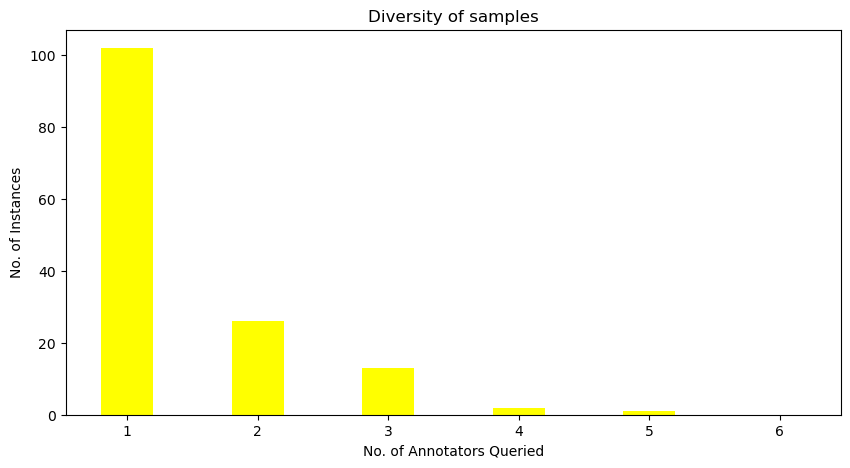

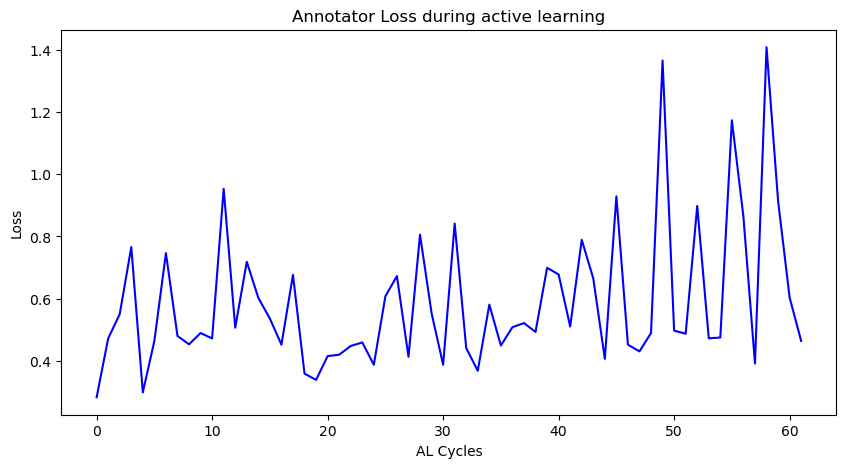

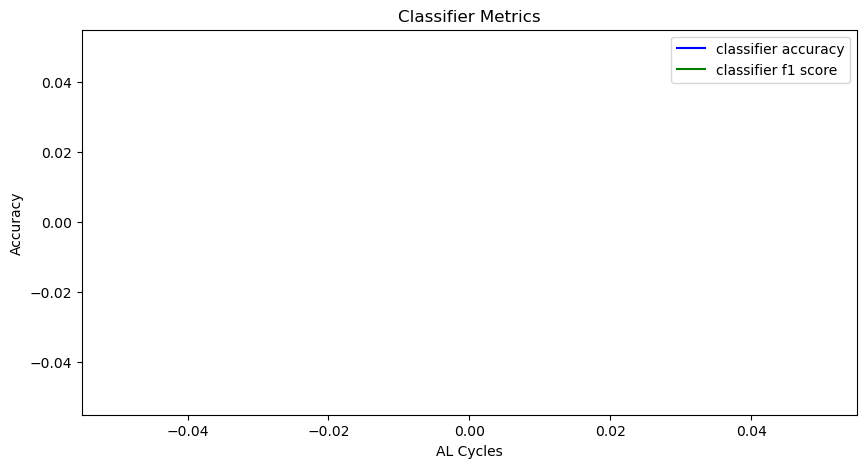

In [135]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(loss, color ='blue')
plt.xlabel("AL Cycles") 
plt.ylabel("Loss")
plt.title("Annotator Loss during active learning")
plt.show()


fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_AM)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_AM)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [136]:
df_c_AM = pd.DataFrame(data_c_AM,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_AM

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.882353,0.916667,0.634783,0.746988,0.773913,0.857143
W Optimal,1.000000,1.000000,0.600000,0.729412,0.721739,0.824176
Majority,0.823529,0.857143,0.669565,0.768293,0.756522,0.837209
True Labels,1.000000,1.000000,0.600000,0.729412,0.834783,0.897297


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [112]:
df_a_AM = pd.DataFrame(data_a_AM,index=['Weighted Average','Maximum Index'])
df_a_AM

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.882353,0.923077,0.803279,0.850000
Maximum Index,0.882353,0.916667,0.819672,0.857143


## OPTION 2 --- LABELS CHOSEN USING W OPTIMAL ( SCHEME 2 )

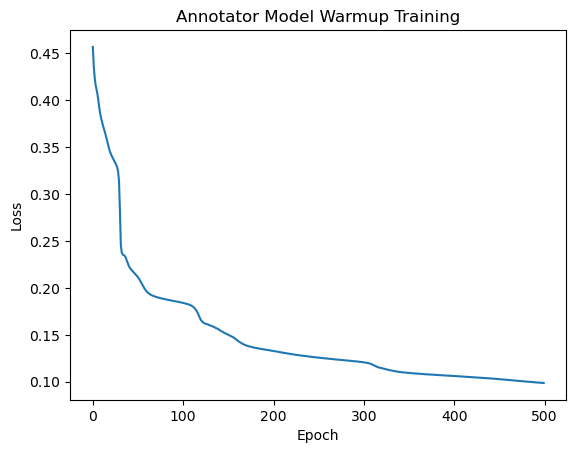

In [113]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_WO)

classifier_model_AM = LR(max_iter = 2000)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 2000)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 2000)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 2000) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_WO)

In [114]:
batch_size = 4
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.0001,scheme = 2,RL_flag = 0, ee_ratio = 0, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 104/104 [00:31<00:00,  3.35it/s]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7536231884057971

F1 Score :  0.8210526315789473

Confusion Matrix
[[13 10]
 [ 7 39]]

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.57      0.60        23
           1       0.80      0.85      0.82        46

    accuracy                           0.75        69
   macro avg       0.72      0.71      0.71        69
weighted avg       0.75      0.75      0.75        69



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.855072463768116

F1 Score :  0.8979591836734694

Confusion Matrix
[[15  5]
 [ 5 44]]

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.90      0.90      0.90        49

    accuracy                           0.86        69
   macro avg       0.82      0.82      0.82        69
weighted avg       0.86      0.86      0.86        69



MAJORITY LABELS

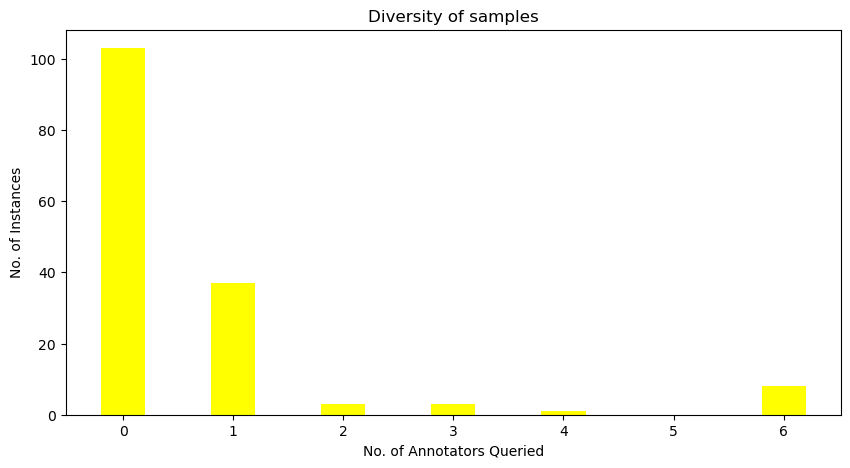

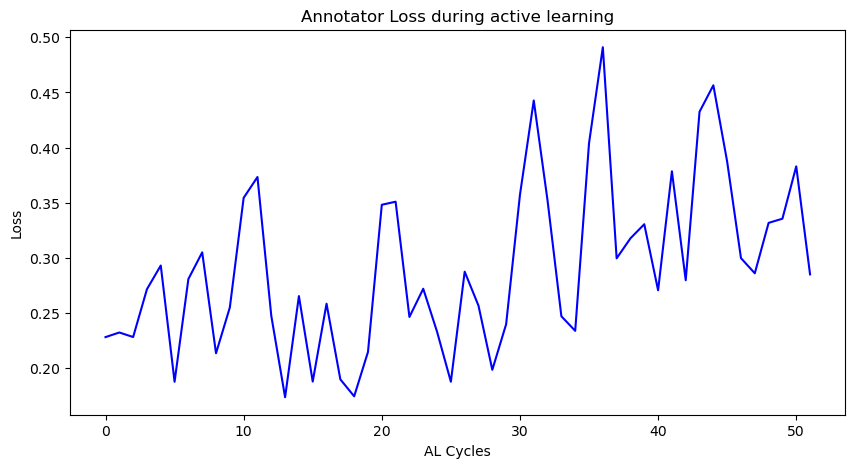

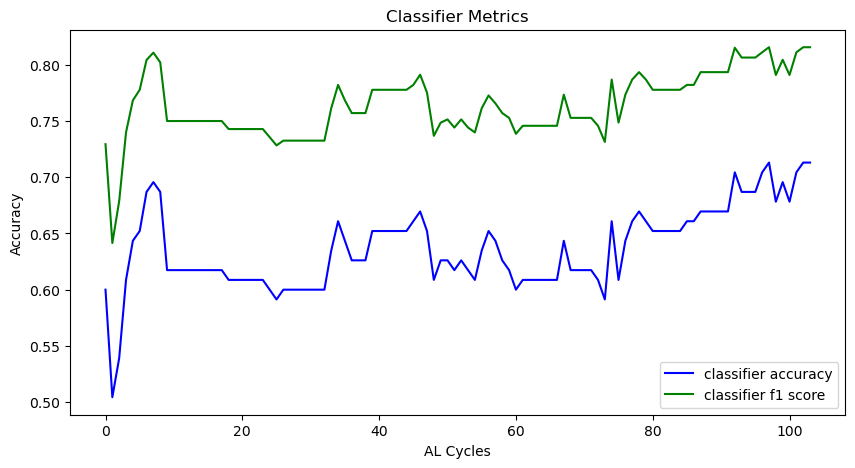

In [115]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(loss, color ='blue')
plt.xlabel("AL Cycles")
plt.ylabel("Loss")
plt.title("Annotator Loss during active learning")
plt.show()

fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_WO)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_WO)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [116]:
df_c_WO = pd.DataFrame(data_c_WO,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_WO

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.823529,0.857143,0.513043,0.626667,0.704348,0.806818
W Optimal,1.000000,1.000000,0.600000,0.729412,0.713043,0.815642
Majority,0.823529,0.857143,0.669565,0.768293,0.626087,0.745562
True Labels,1.000000,1.000000,0.600000,0.729412,0.765217,0.857143


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [117]:
df_a_WO = pd.DataFrame(data_a_WO,index=['Weighted Average','Maximum Index'])
df_a_WO

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.941176,0.956522,0.811594,0.865979
Maximum Index,0.823529,0.857143,0.768116,0.829787


## OPTION 3 --- EXPLORATION EXPLOITATION USING LABELS FROM ANNOTATOR MODEL ( SCHEME 1 )

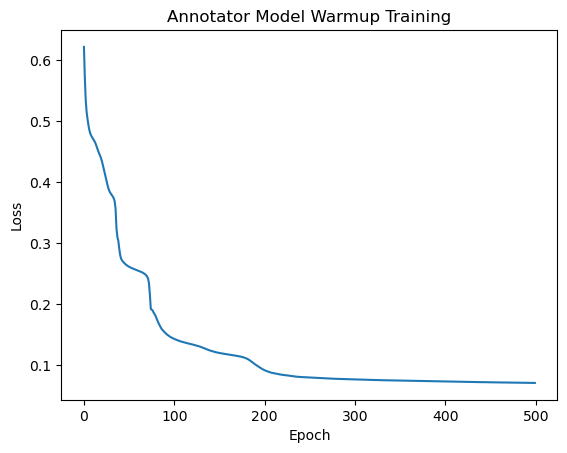

In [118]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_AM_EE)

classifier_model_AM = LR(max_iter = 800)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 800)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 800)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 800) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_AM_EE)

In [119]:
batch_size = 4
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.01,scheme = 1,RL_flag = 1, ee_ratio = 0.7, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 104/104 [00:24<00:00,  4.25it/s]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7884615384615384

F1 Score :  0.8405797101449276

Confusion Matrix
[[12  6]
 [ 5 29]]

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.83      0.85      0.84        34

    accuracy                           0.79        52
   macro avg       0.77      0.76      0.76        52
weighted avg       0.79      0.79      0.79        52



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8653846153846154

F1 Score :  0.8985507246376812

Confusion Matrix
[[14  4]
 [ 3 31]]

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.89      0.91      0.90        34

    accuracy                           0.87        52
   macro avg       0.85      0.84      0.85        52
weighted avg       0.86      0.87      0.86        52



MAJORITY LABEL

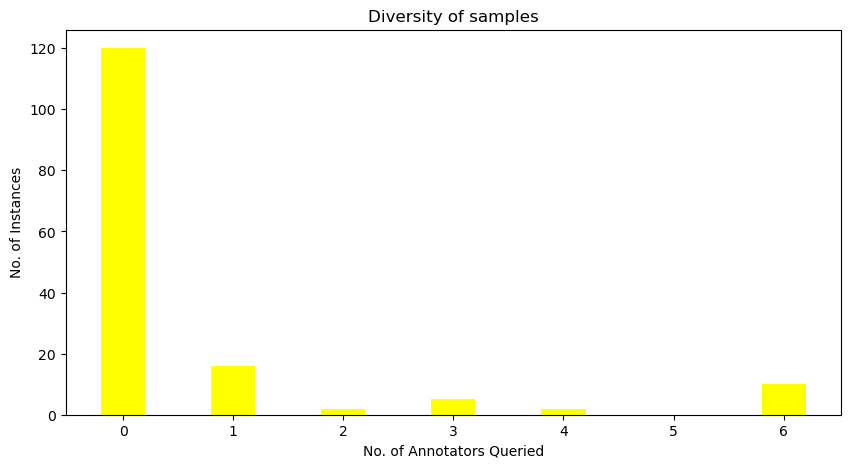

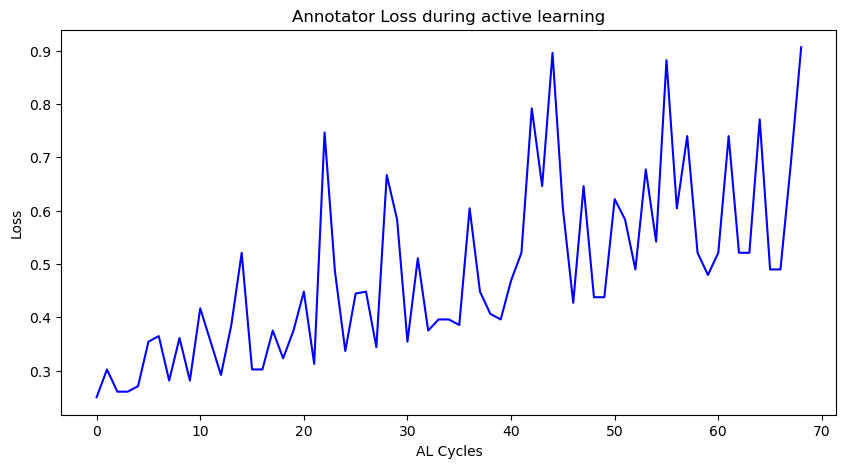

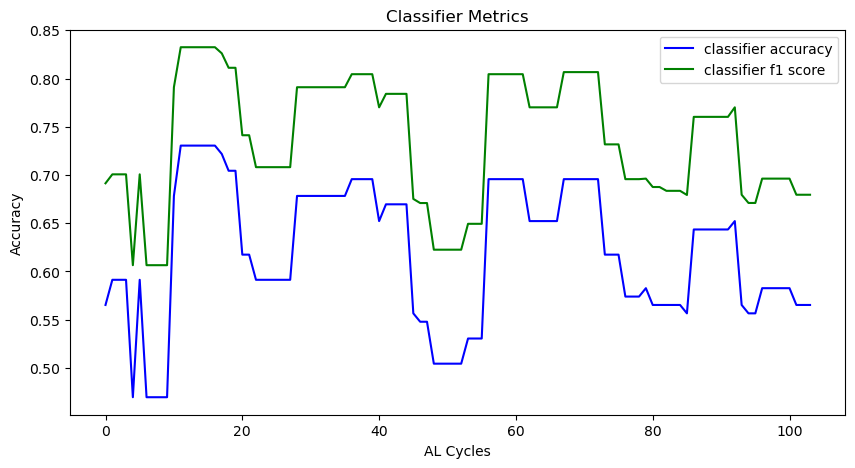

In [120]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(loss, color ='blue')
plt.xlabel("AL Cycles")
plt.ylabel("Loss")
plt.title("Annotator Loss during active learning")
plt.show()

fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_AM_EE)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_AM_EE)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE WITH EXPLOITATION EXPLORATION RATIO

In [121]:
df_c_AM_EE = pd.DataFrame(data_c_AM_EE,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_AM_EE

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.764706,0.833333,0.556522,0.687117,0.565217,0.679487
W Optimal,1.000000,1.000000,0.600000,0.729412,0.626087,0.729560
Majority,0.823529,0.857143,0.669565,0.768293,0.504348,0.601399
True Labels,1.000000,1.000000,0.600000,0.729412,0.626087,0.736196


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE WITH EXPLOITATION EXPLORATION RATIO 

In [122]:
df_a_AM_EE = pd.DataFrame(data_a_AM_EE,index=['Weighted Average','Maximum Index'])
df_a_AM_EE

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.882353,0.909091,0.692308,0.75
Maximum Index,0.764706,0.833333,0.750000,0.80


In [123]:
from sklearn.metrics import accuracy_score
y_ones = np.ones_like(y_val)
accuracy_score(y_val,y_ones)

0.808695652173913

## OPTION 4 --- MAJORITY LABELS

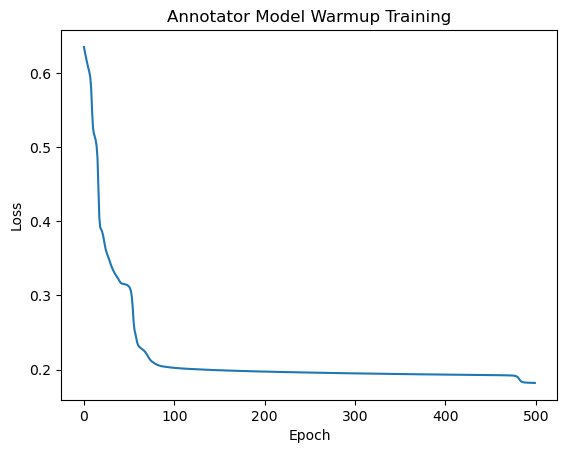

In [124]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = 'cpu')
    annot_eval_after_warmup(annotator_model, BOOT, data_a_M)
    
classifier_model_AM = LR(max_iter = 800)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 800)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 800)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 800) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_M)

In [125]:
batch_size = 4
Classifiers,idx,collected_data,loss, inst_annot,full, c_a, c_f = AL_train_majority(Classifiers,Classifiers_y_boot,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.00001, device = device)
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_data
## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 104/104 [00:05<00:00, 19.56it/s]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7936507936507936

F1 Score :  0.8470588235294118

Confusion Matrix
[[14  9]
 [ 4 36]]

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        23
           1       0.80      0.90      0.85        40

    accuracy                           0.79        63
   macro avg       0.79      0.75      0.76        63
weighted avg       0.79      0.79      0.79        63



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.9047619047619048

F1 Score :  0.9302325581395349

Confusion Matrix
[[17  5]
 [ 1 40]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.77      0.85        22
           1       0.89      0.98      0.93        41

    accuracy                           0.90        63
   macro avg       0.92      0.87      0.89        63
weighted avg       0.91      0.90      0.90        63



MAJORITY LABEL

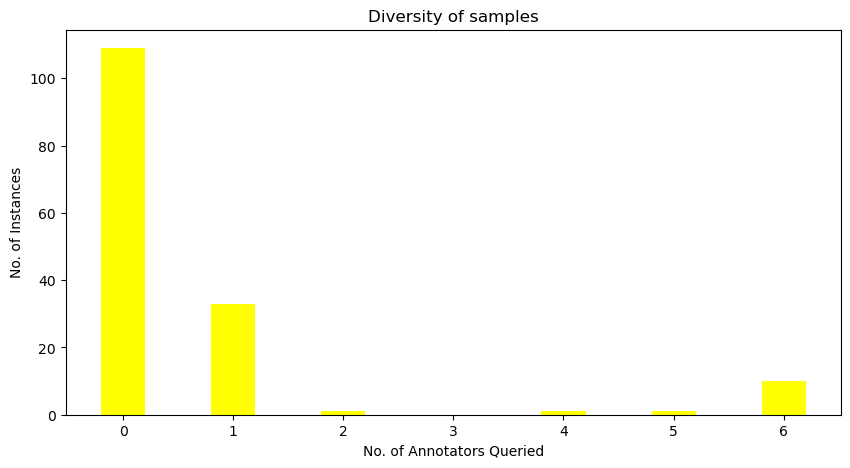

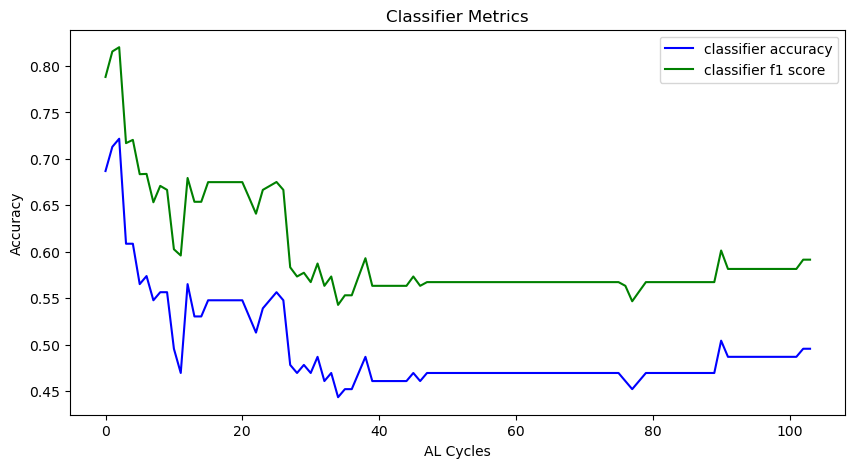

In [126]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_M)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_M)

CLASSIFIER METRICS AFTER ACTIVE LEARNING CYCLE

In [127]:
df_c_M = pd.DataFrame(data_c_M[2:],index = ['Majority','True Labels'])
df_c_M

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Majority,0.823529,0.857143,0.669565,0.768293,0.495652,0.591549
True Labels,1.000000,1.000000,0.600000,0.729412,0.626087,0.742515


## OPTION 5 --- TRAIN ON INSTANCES FROM MAPAL

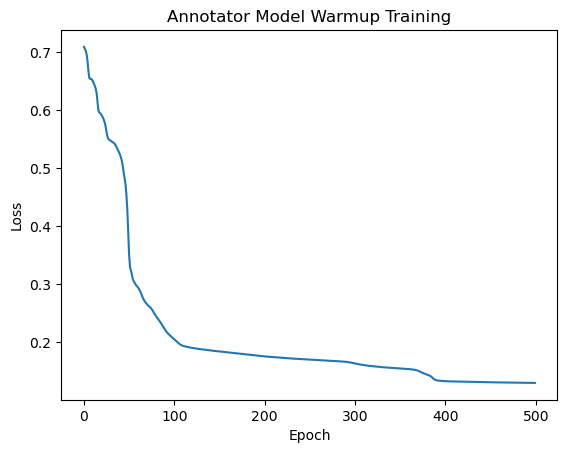

In [128]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_MAPAL)

classifier_model_AM = LR(max_iter = 2000)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 2000)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 2000)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 2000) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_MAPAL)

In [129]:
batch_size = 4
Classifiers, annotator_model,collected_active_data, loss, inst_annot, full, c_a,c_f = AL_train_MAPAL_instances(Classifiers,Classifiers_y_boot,annotator_model,ordered_instances,BOOT.copy(),ACTIVE.copy(),VAL.copy(),Mapal_Data,W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.00001, device = device)
new_active_x,new_active_y,new_active_y_opt,new_active_y_majority, new_active_y_true,new_active_y_annot, new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 206/206 [00:56<00:00,  3.68it/s]


In [130]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.782608695652174

F1 Score :  0.835680751173709

Confusion Matrix
[[37 20]
 [15 89]]

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        57
           1       0.82      0.86      0.84       104

    accuracy                           0.78       161
   macro avg       0.76      0.75      0.76       161
weighted avg       0.78      0.78      0.78       161



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8074534161490683

F1 Score :  0.8544600938967136

Confusion Matrix
[[39 18]
 [13 91]]

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.68      0.72        57
           1       0.83      0.88      0.85       104

    accuracy                           0.81       161
   macro avg       0.79      0.78      0.79       161
weighted avg       0.80      0.81      0.81       161



MAJORITY LABELS 

In [131]:
print((new_active_y_majority==new_active_y_opt).sum())
print((new_active_y==new_active_y_opt).sum())
print((new_active_y==new_active_y_majority).sum())

0    154
dtype: int64
0    149
dtype: int64
0    146
dtype: int64


In [132]:
print('USING MAPAL SELECTED INSTANCES')
print_scores(Classifiers,VAL)

USING MAPAL SELECTED INSTANCES

Labels from Annotator Model
Accuracy :  0.7739130434782608
F1 Score :  0.8571428571428572
[[11 15]
 [11 78]]
              precision    recall  f1-score   support

           0       0.50      0.42      0.46        26
           1       0.84      0.88      0.86        89

    accuracy                           0.77       115
   macro avg       0.67      0.65      0.66       115
weighted avg       0.76      0.77      0.77       115


Labels from W optimal
Accuracy :  0.7217391304347827
F1 Score :  0.8241758241758241
[[ 8 18]
 [14 75]]
              precision    recall  f1-score   support

           0       0.36      0.31      0.33        26
           1       0.81      0.84      0.82        89

    accuracy                           0.72       115
   macro avg       0.59      0.58      0.58       115
weighted avg       0.71      0.72      0.71       115


Labels from Majority
Accuracy :  0.7565217391304347
F1 Score :  0.8372093023255814
[[15 21]
 [ 7 72]

[1, 2, 3, 4, 5, 6] [102, 26, 13, 2, 1, 0]


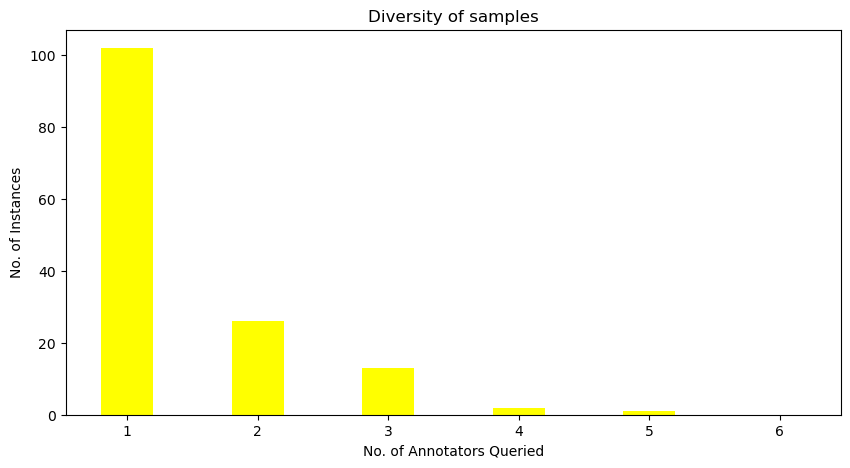

In [133]:
diverse_samples(inst_annot,full)

During BOOT we have all annotations -- train Annotator Model

Create Knowledge Base for each annotator. Instances providing Weights above threshold will be collected in the Knowledge base of that particular annotator.

SET SEEDS AT ALL PLACES SUCH AS TORCH, NUMPY ETC. RUN MULTIPLE TIMES AND CHECK
CLEAN CODE 
SET SEEDS AT ALL PLACES SUCH AS TORCH, NUMPY ETC. RUN MULTIPLE TIMES AND CHECK
SHARE RESULTS WITH ENTROPY BASED
ACCURACY OF TRAINING SET
DISPLAY DIVERSE SAMPLES
TRY EXPLORE EXPLOIT WITH DIFFERENT THRESHOLDS 
WEIGHTED INDEX FOR ANNOTATOR MODEL
CREATE NEW BRANCH AND PUSH FRESH CODE 